## Import libraries

In [118]:
import numpy as np 

import scipy as sp
import scipy.linalg as la   # la.eig()
import scipy.integrate
from scipy.integrate import odeint
from scipy.linalg import eigh  

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.sans-serif']=['SimHei']  
plt.rcParams['axes.unicode_minus']=False   

## One-meter beam is divided into ten parts

In [119]:
L = 1               # Beam length = 1 m
num_elems = 10      # divided into 10 parts
x = np.linspace(0,L,num_elems+1)   # x.shape =11

# ini_shape= [ 0 for i in range(num_elems+1) ]
# plt.figure()
# plt.plot(x,ini_shape,marker='*')
# plt.title("initial displacement")

# plt.figure()
# plt.plot(x,ini_shape,marker='*')
# plt.title("initial velocity")

## Define material properties and element properties

In [120]:
l = x[1]-x[0]       # element length            m
E = 210*10**9       # Young's modulus           Pa
u = 0.3             # Poisson's ratio
I = 6.51*10**-8     # Moment of inertia         m^4
Rho = 7860          # Material density          kg/m3
cc = 0.01           # Damping coefficient
q = 10              # Distribution force        N
A =  5*25*10**-4    # Cross-sectional area      m^2

t_max = 10          # max time 
t_totality = 101    # total number of timestep , control stepsize
t = np.linspace(0, t_max, t_totality)       # time series

k = (E*I/l**3)*np.array(  [ [ 12,  6*l,    -12,   6*l    ],                     # element Stiffness matrix
                            [ 6*l, 4*l**2, -6*l,  2*l**2 ],
                            [ -12, -6*l,    12,  -6*l    ],
                            [ 6*l, 2*l**2, -6*l,  4*l**2 ] ])

m = (Rho*A*l/420)*np.array([[ 156,    22*l,    54,    -13*l    ],               # element mass matrix
                            [ 22*l,   4*l**2,  13*l,  -3*l**2  ],
                            [ 54,     13*l,    156,   -22*l    ],
                            [ -13*l, -3*l**2, -22*l,   4*l**2  ] ])
c = m*(cc/Rho)                               # element damping matrix 
f = np.array([0.5*q*l,0,0.5*q*l,0])          # element force matrix

## Assemble the overall matrix

In [121]:
def beam_matrx_add(num_elems):
    """
    input:  Number of element
    return: M_end : Overall mass matrix without fixed end constraints
            K_end : Overall stiffness matrix without fixed end constraints
            C_end : Overall damping matrix without fixed end constraints
            F_end : Overall force matrix without fixed end constraints
            F     : Overall force matrix
    """
    M_all = np.zeros((2*num_elems+2,2*num_elems+2))
    K_all = np.zeros((2*num_elems+2,2*num_elems+2))
    C_all = np.zeros((2*num_elems+2,2*num_elems+2))
    F_all = np.zeros(2*num_elems+2)
    
    for i in range(num_elems):
        M_temp = np.zeros((2*num_elems+2,2*num_elems+2))
        K_temp = np.zeros((2*num_elems+2,2*num_elems+2))
        C_temp = np.zeros((2*num_elems+2,2*num_elems+2))
        F_temp = np.zeros(2*num_elems+2)
        M_temp[2*i:2*i+4, 2*i:2*i+4] = m    
        K_temp[2*i:2*i+4, 2*i:2*i+4] = k    # Slice assignment
        C_temp[2*i:2*i+4, 2*i:2*i+4] = c
        F_temp[2*i:2*i+4] = f
        M_all += M_temp
        K_all += K_temp
        C_all += C_temp
        F_all += F_temp
    M = M_all[2:,2:]    # Remove fixed end degrees of freedom: The first two rows and the first two columns
    K = K_all[2:,2:]
    C = C_all[2:,2:]
    F = F_all[2:]
    return M , K , C, F , F_all
    
M , K , C , F_end , F = beam_matrx_add( num_elems ) # K.shape =(20, 20)
M.shape

(20, 20)

## calculate the eigenvalue and the corresponding eigenvector

In [122]:
omega_2, fai = eigh(K,M)    # Return eigenvalues ​​and eigenvectors
omega = np.sqrt(omega_2)    # omega.shape = 20 # fai.shape = (20, 20)
omega_1 = omega[0]
print(omega)

[4.14748655e+01 2.59926926e+02 7.27964128e+02 1.42751510e+03
 2.36348092e+03 3.54076320e+03 4.96786259e+03 6.65556637e+03
 8.60556459e+03 1.06979583e+04 1.42385078e+04 1.72019113e+04
 2.08527161e+04 2.51678370e+04 3.02428656e+04 3.61706999e+04
 4.29290121e+04 5.01175785e+04 5.64379557e+04 7.06314383e+04]


# free vibration

D:\aMyCodeGroup\Anaconda\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
result of Generalized Coordinates : result.shape = (101, 20)
result of original coordinates: x_result.shape =  (20, 101)


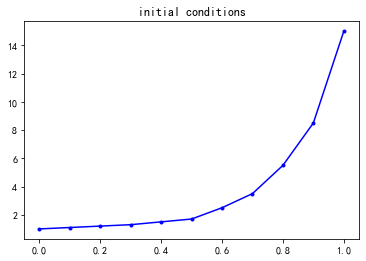

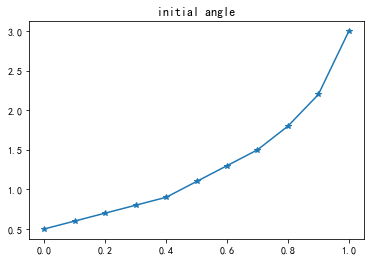

In [123]:
result = np.zeros(    ( t_totality,len(omega)  )     )
                    #   1    2    3    4    5    6    7    8    9    10
F_endpoint = np.array([0,0, 0,0, 0,0, 0,0, 0,0, 0,0, 0,0, 0,0, 0,0, 10,0])

y00 = np.array( [   [1,0,0.5,0],         # 0 ICs matrix: u1 u1'  theta1 theta1'……
                    [1.1,0,0.6,0],       # 1
                    [1.2,0,0.7,0],       # 2
                    [1.3,0,0.8,0],       # 3
                    [1.5,0,0.9,0],       # 4
                    [1.7,0,1.1,0],       # 5
                    [2.5,0,1.3,0],       # 6
                    [3.5,0,1.5,0],       # 7
                    [5.5,0,1.8,0],       # 8
                    [8.5,0,2.2,0],       # 9
                    [15,0,3,0]   ] )     # 10

plt.plot(x,y00[:,0],'-b',marker='.')
plt.title("initial conditions")
plt.figure()
plt.plot(x,y00[:,2],marker='*')
plt.title("initial angle")

y01 = fai.T @ y00[1:,:].reshape(-1,2) # (20, 2)
y01=y01.reshape(1,-1)   # (1, 40)

def diff(y,t):                                      # define ODE 
    yt, theta = y
    return theta , (F_i-K_i*yt-C_i*theta) / M_i

for i in range( len(omega) ):           # Calculate the ODE corresponding to each eigenvalue
    M_i = (fai[:,i].T) @ M @ fai[:,i] 
    K_i = (fai[:,i].T) @ K @ fai[:,i] 
    C_i = (fai[:,i].T) @ C @ fai[:,i] 
    F_i = (fai[:,i].T) @ F_endpoint 
    
    y0 = [ y01[0,(2*i)],y01[0,(2*i+1)] ]                          # initial conditions
    
    sol = odeint(diff, y0, t)           # Call the odeint function to solve
    result[:,i] += sol[:,0]             # Put the result of each solution into the  "result" matrix
    

print("result of Generalized Coordinates : result.shape =",result.shape) # =(101,20)


x_result = np.zeros((len(omega),t_totality))   # (20,101) #  result of original coordinates
for i in range(len(omega)):
    x_result += fai[:,i].reshape(-1,1) @ result[:,i].reshape(1,-1) 

print("result of original coordinates: x_result.shape = ",x_result.shape) # =(20, 101)

Text(0.5, 0.92, 'angle $\\theta$ change ')

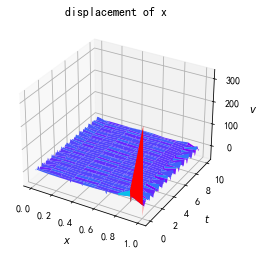

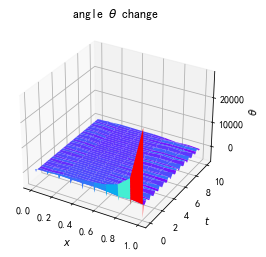

In [124]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
X,T = np.meshgrid( np.linspace(0,1,num_elems),t )
ax.plot_surface(X,T,x_result[::2,::].T,cmap='rainbow')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$v$')
ax.set_title('displacement of x')


fig1 = plt.figure()
ax = fig1.add_subplot(111,projection = '3d')
X,T = np.meshgrid( np.linspace(0,1,num_elems),t )
ax.plot_surface(X,T,x_result[1:2*num_elems:2,::].T,cmap='rainbow')
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel(r'$\theta $')
ax.set_title('angle 'r'$\theta$ change ')

Text(0.5, 1.0, 'displacement v at the midpoint')

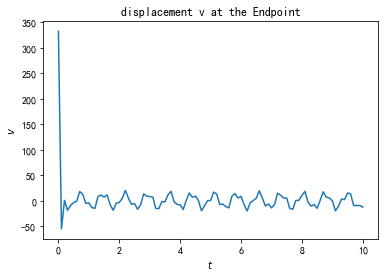

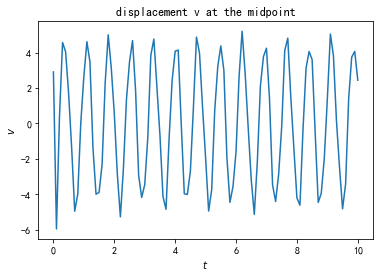

In [125]:
plt.figure()
plt.plot( t,x_result[18,:])
plt.xlabel('$t$')
plt.ylabel('$v$')
plt.title('displacement v at the Endpoint')

plt.figure()
plt.plot( t,x_result[8,:])
plt.xlabel('$t$')
plt.ylabel('$v$')
plt.title('displacement v at the midpoint')

Text(0.5, 1.0, 'angle $\\theta$ change at the midpoint')

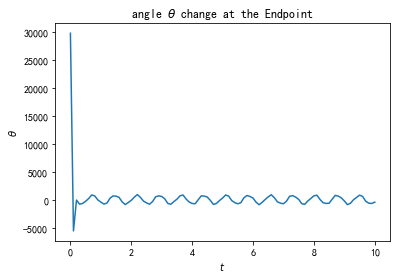

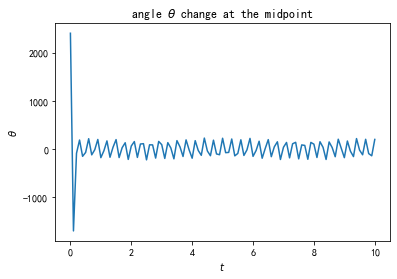

In [126]:
plt.figure()
plt.plot( t,x_result[19,:])
plt.xlabel('$t$')
plt.ylabel(r'$\theta $')
plt.title('angle 'r'$\theta$ change at the Endpoint')
plt.figure()
plt.plot( t,x_result[9,:])
plt.xlabel('$t$')
plt.ylabel(r'$\theta $')
plt.title('angle 'r'$\theta$ change at the midpoint')